# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [123]:
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

# Statsmodel
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

# Scikit learn
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# Viz mantra
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [124]:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [125]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [126]:
sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [127]:
num_rows, num_columns = sensor.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 1751
Number of columns: 12


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [128]:
date = pd.date_range("1/1/2018 00:00:00 ", "1/1/2018 00:29:10", periods = 1751)
date

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

In [129]:
sensor.index = date
infered_freq = pd.infer_freq(sensor.index)
infered_freq

'S'

Assign the time series index to the dataframe's index.

In [130]:
sensor.index.freq = infered_freq
sensor.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq='S')

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

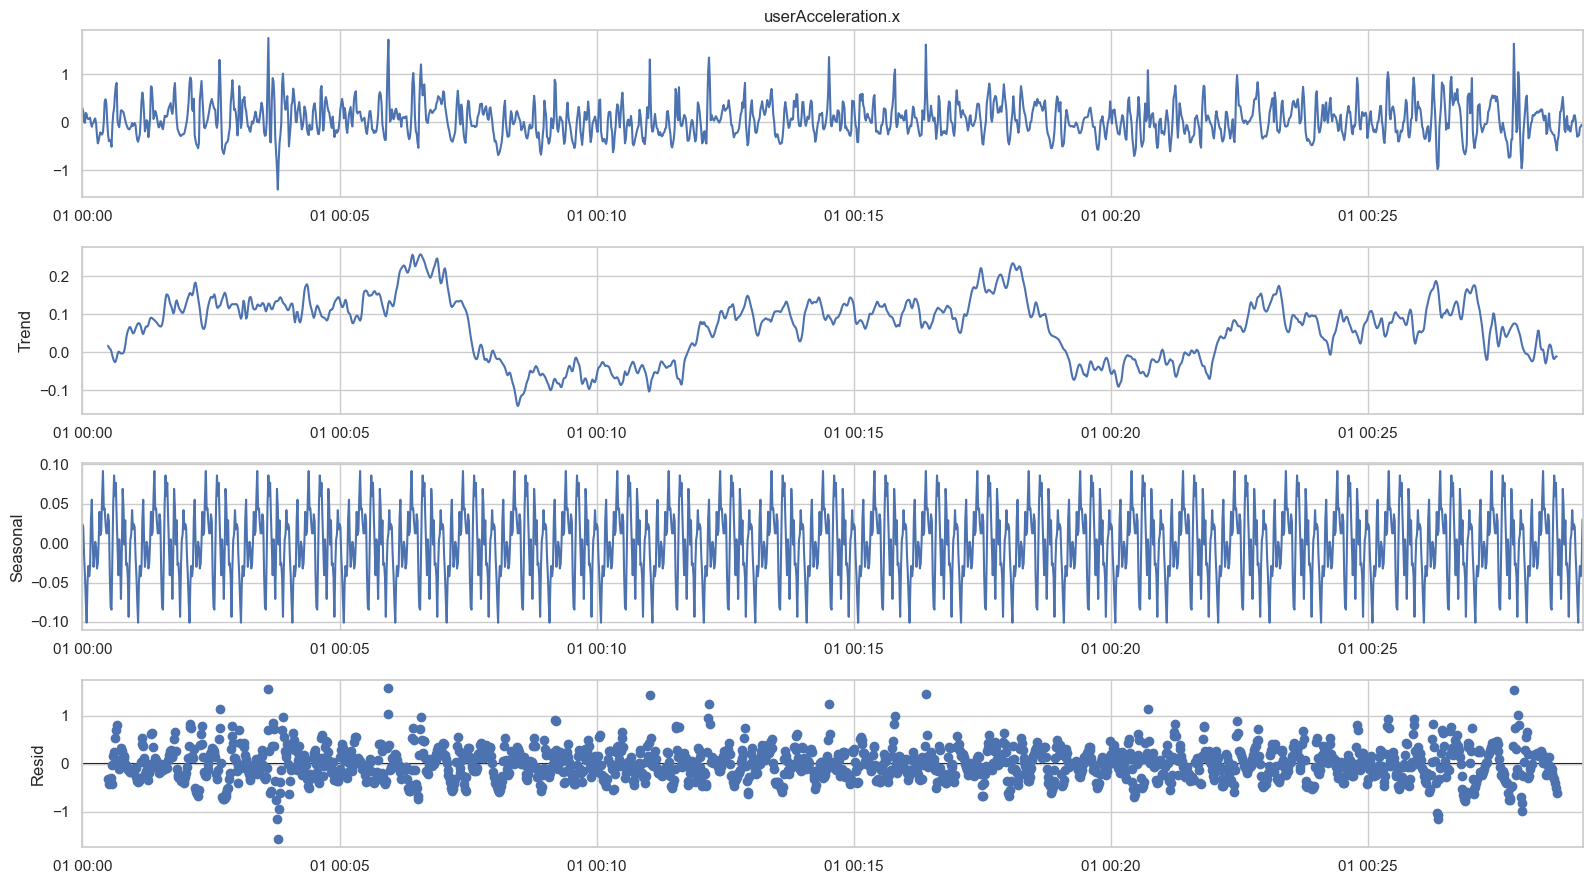

In [131]:
descomposed = seasonal_decompose(sensor['userAcceleration.x'], period=60)
descomposed.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

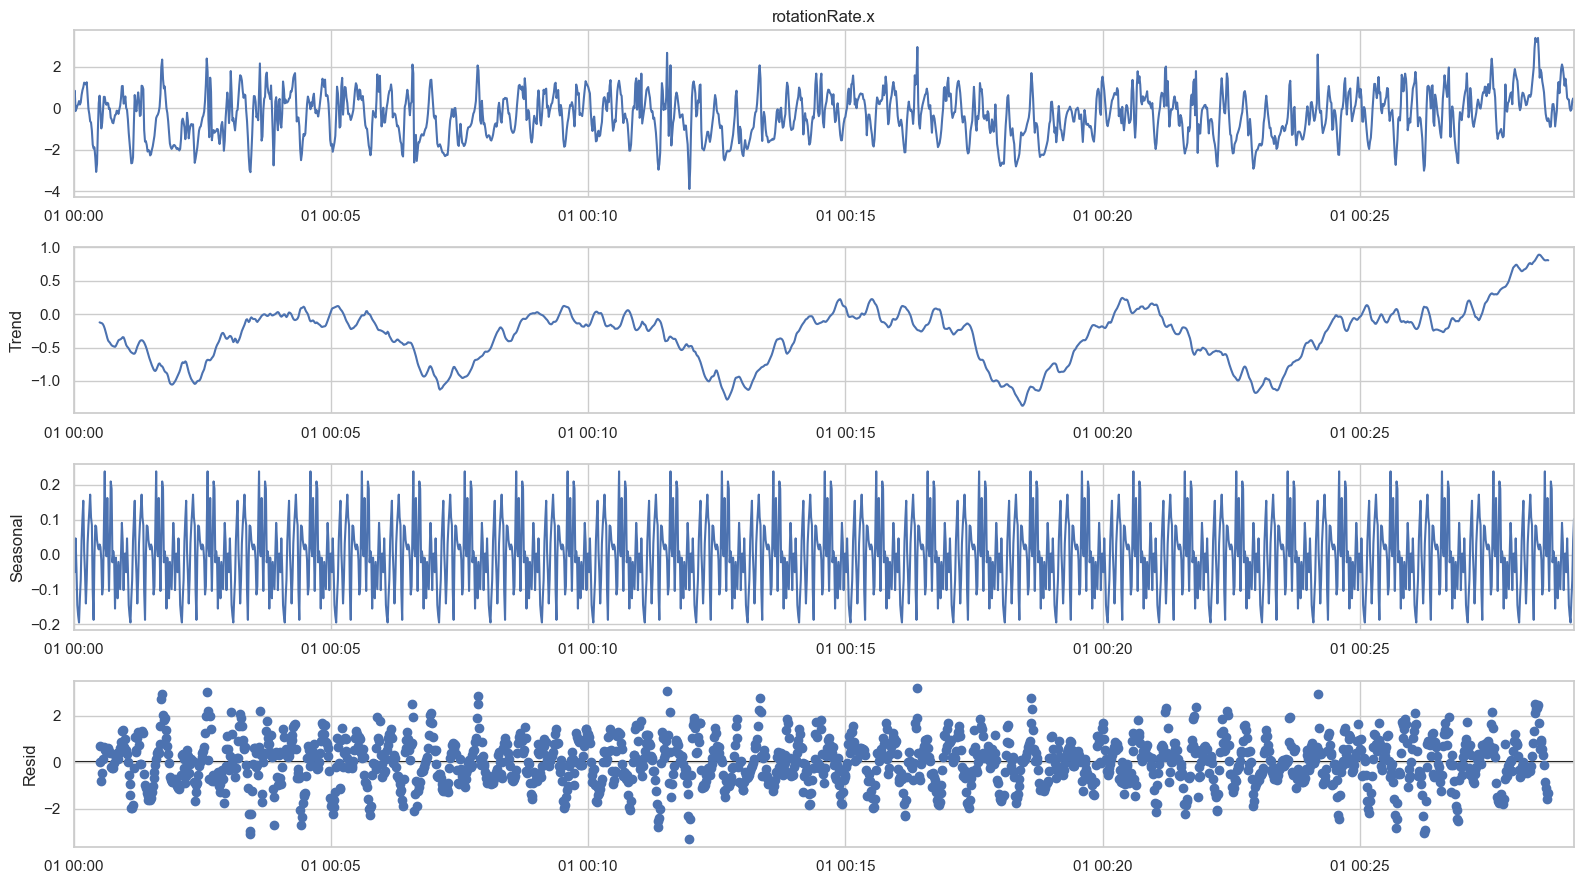

In [132]:
descomposed_series = seasonal_decompose(sensor['rotationRate.x'], period=60)
descomposed_series.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

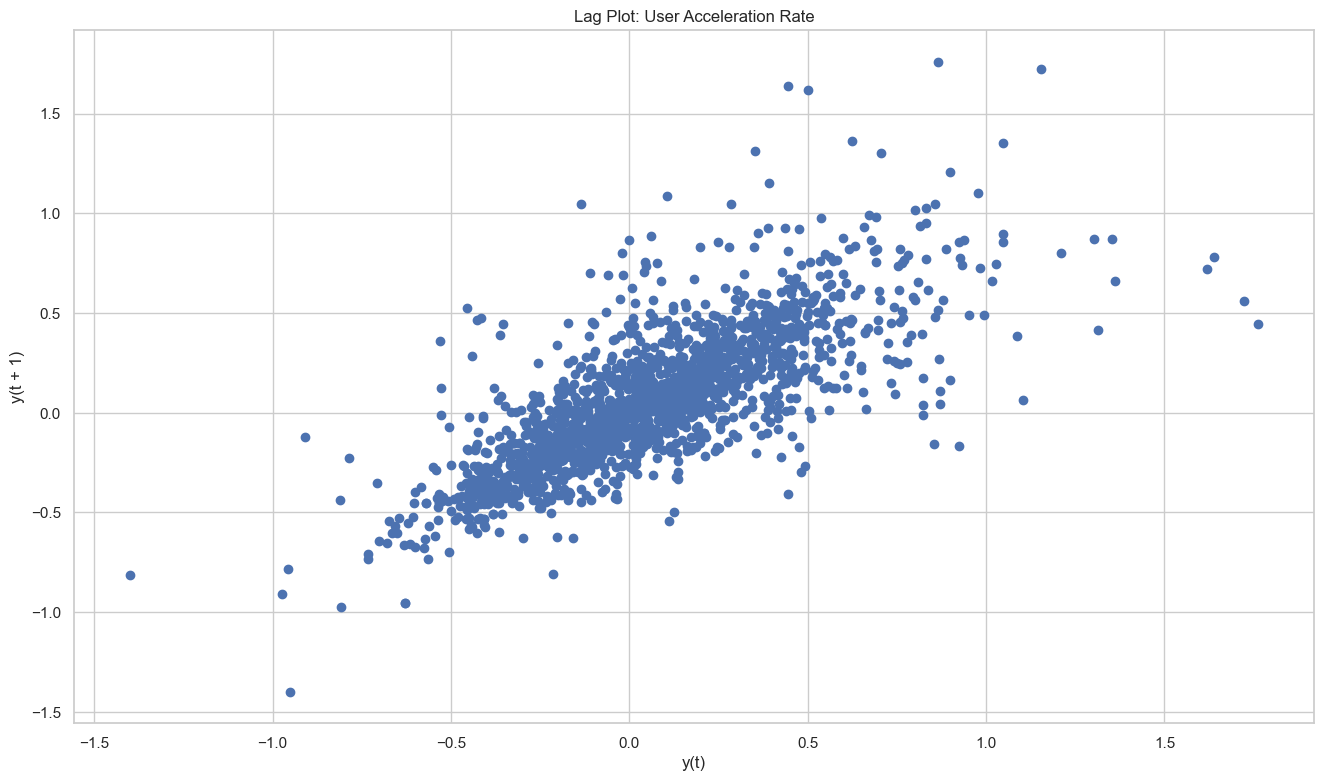

In [133]:
pd.plotting.lag_plot(sensor['userAcceleration.x'], lag=1)
plt.title("Lag Plot: User Acceleration Rate");

Create a lag plot for `rotationRate.x`

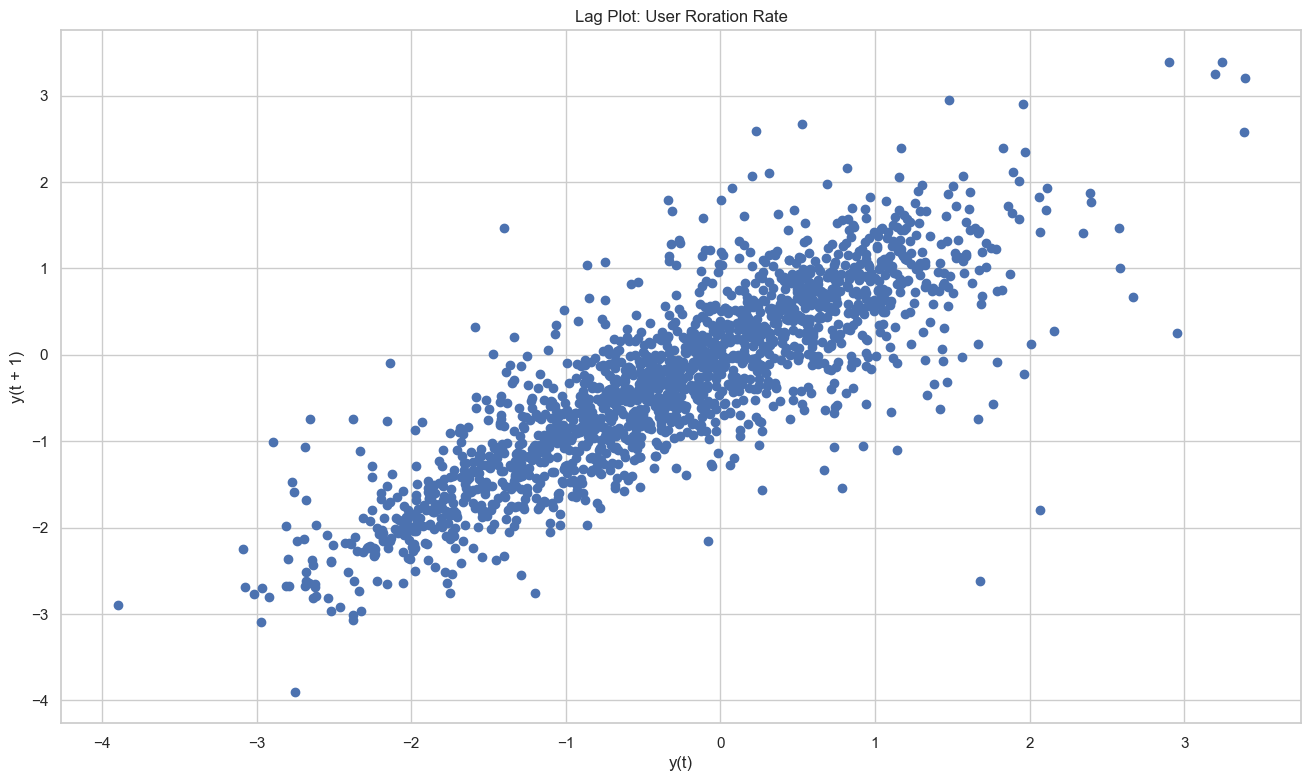

In [134]:
pd.plotting.lag_plot(sensor['rotationRate.x'], lag=1)
plt.title("Lag Plot: User Roration Rate");

What are your conclusions from both visualizations?

Answer: The first lag plot suggests a moderate positive linear autocorrelation with a tight clustering of data points around the diagonal, while the second plot shows a broader spread indicating a weaker autocorrelation with more variability and potential outliers. The second plot's wider dispersion suggests more volatility in the time series data at a one-period lag.

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [135]:
#useracceleration
adf_acceleration = adfuller(sensor['userAcceleration.x'])
print(f'ADF Statistic for userAcceleration.x: {adf_acceleration[0]}')
print(f'p-value for userAcceleration.x: {adf_acceleration[1]}')

#useracceleration
adf_rotation = adfuller(sensor['rotationRate.x'])
print(f'ADF for Rotation: {adf_rotation[0]}')
print(f'p-value for Rotation: {adf_rotation[1]}')

ADF Statistic for userAcceleration.x: -17.95799408616974
p-value for userAcceleration.x: 2.823439483037563e-30
ADF for Rotation: -5.269860625086421
p-value for Rotation: 6.320230335912189e-06


What are your conclusions from this test?

Answer: The ADF test results for userAcceleration.x show a highly negative statistic of -17.957994 and a practically zero p-value of 2.82e-30, strongly suggesting stationarity in the series. Similarly, the Rotation time series exhibits a negative ADF statistic of -5.269860 and a very low p-value of 6.32e-06, indicating it is also stationary. These findings collectively imply that both userAcceleration.x and Rotation do not have unit roots and are stable over time.

## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [136]:
order = (2, 0, 1)

In [137]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [138]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html

model = ARIMA(y_train, order = (2, 0, 1), freq='S')

In [163]:
# 2. Fit the model:

model = ARIMA(y_train, order = (2, 0, 1), freq='S')
model = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     userAcceleration.x   No. Observations:                 1741
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 373.401
Date:                Tue, 14 Nov 2023   AIC                           -736.803
Time:                        16:30:12   BIC                           -709.492
Sample:                    01-01-2018   HQIC                          -726.704
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0637      0.016      3.994      0.000       0.032       0.095
ar.L1          0.9882      0.036     27.630      0.000       0.918       1.058
ar.L2         -0.3788      0.033    -11.637      0.0

In [166]:
# 3. Predict: create y_pred:

sensor["forecasting_arima"] = model_fit.predict(start=len(sensor['userAcceleration.x']) - 1000, end=len(sensor['userAcceleration.x']) +1000)
y_pred = sensor["forecasting_arima"]

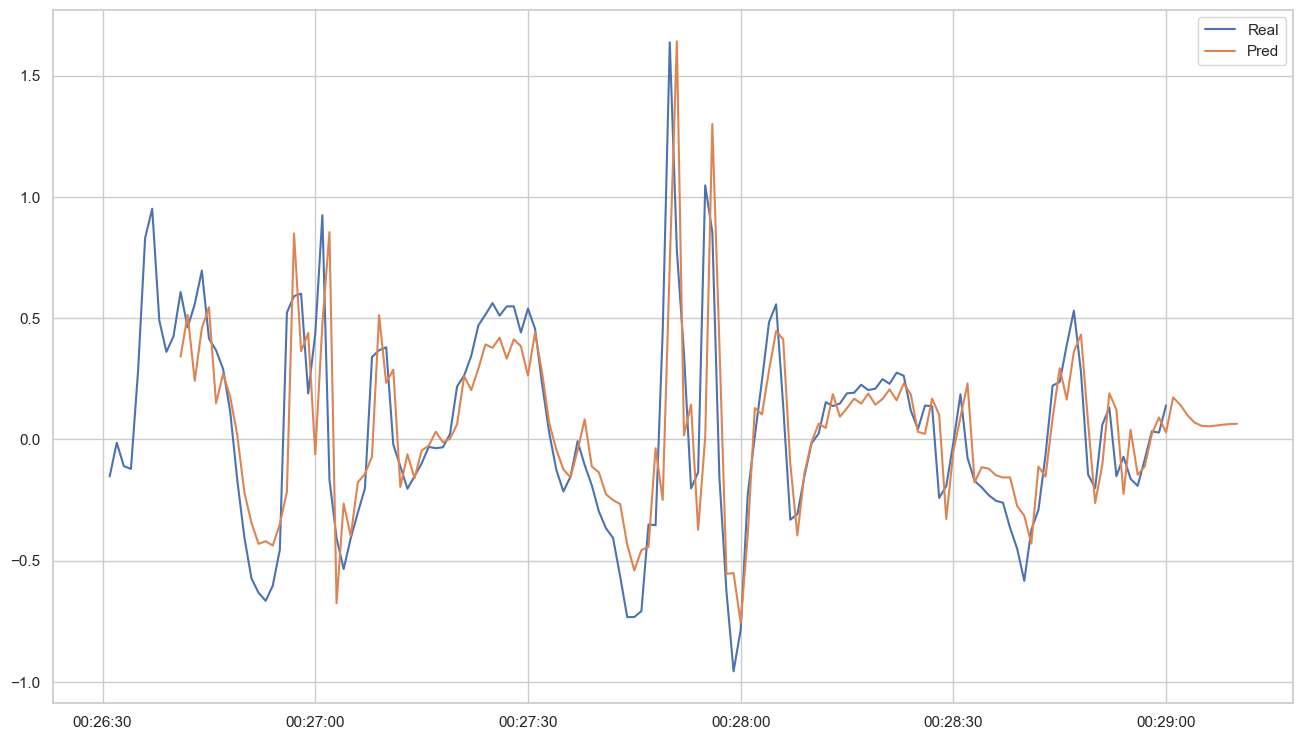

In [167]:
# 4. Visualize
plt.plot(y_train[-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Pred")
plt.legend();

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [168]:
# Your code here:

actual_values = sensor['userAcceleration.x'][-10:]
predicted_values = sensor['forecasting_arima'][-10:]

rmse_value = rmse(actual_values, predicted_values)

print("RMSE(Root Mean Squared Error):", rmse_value)

RMSE(Root Mean Squared Error): 0.22529160449894864
